In [ ]:
!wget https://raw.githubusercontent.com/mufaddalhamidofficial/tensorflow_course/main/helper_funcs.py

--2024-01-21 18:32:39--  https://raw.githubusercontent.com/mufaddalhamidofficial/tensorflow_course/main/helper_funcs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11905 (12K) [text/plain]
Saving to: ‘helper_funcs.py.1’

helper_funcs.py.1   100%[===================>]  11.63K  --.-KB/s    in 0s      

2024-01-21 18:32:39 (87.5 MB/s) - ‘helper_funcs.py.1’ saved [11905/11905]



In [51]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from helper_funcs import create_tensorboard_callback, create_checkpoint_callback, plot_loss_curves, compare_historys, unzip_data, calculate_results
import tensorflow_hub as hub

In [52]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [53]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

ls: /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign: No such file or directory


In [56]:
DIR_NAME = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [57]:
import io

train_file = io.open(f"{DIR_NAME}train.txt")
train_text = train_file.read()
train_file.close()

In [58]:
def get_data(file_name):
    file = io.open(file_name)
    text = file.read()
    file.close()
    array_of_train = list(map(lambda e: e.split("\n")[1:], text.split("\n###")))
    # array_of_train
    train_data = [
        {
            "line_number": i,
            "target": line.split("\t")[0],
            "text": "\t".join(line.split("\t")[1:]).lower(),
            "total_lines": len(elem) - 1,
        }
        for elem in array_of_train
        for i, line in enumerate(elem)
        if line != ""
    ]
    return train_data

In [59]:
train_data = get_data(f"{DIR_NAME}train.txt")
val_data = get_data(f"{DIR_NAME}dev.txt")
test_data = get_data(f"{DIR_NAME}test.txt")
len(train_data), len(val_data), len(test_data)

(180040, 30212, 30135)

In [60]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)
train_df.head(27)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",12
6,6,RESULTS,there was a clinically relevant reduction in t...,12
7,7,RESULTS,the mean difference between treatment arms ( @...,12
8,8,RESULTS,"further , there was a clinically relevant redu...",12
9,9,RESULTS,these differences remained significant at @ we...,12


In [61]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

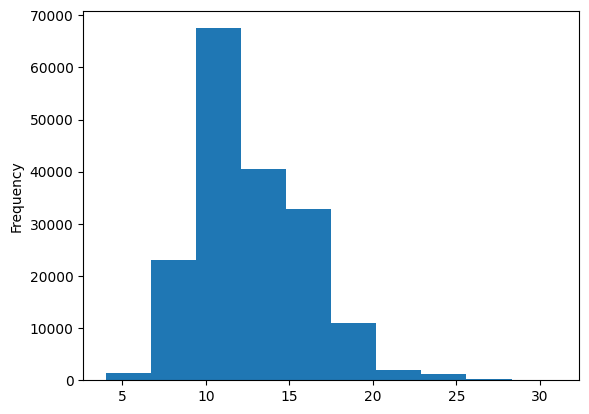

In [62]:
train_df.total_lines.plot.hist()

<Axes: ylabel='Frequency'>

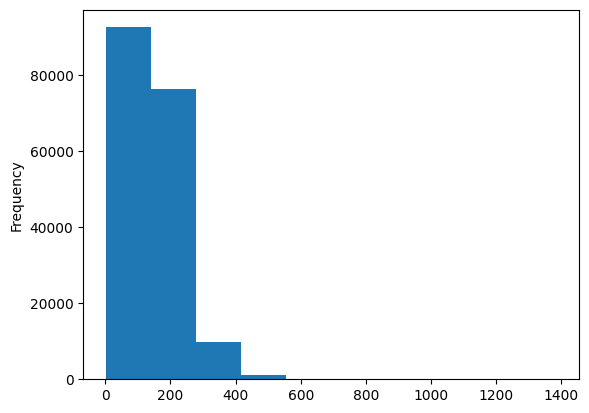

In [63]:
train_df.text.apply(len).plot.hist()

In [64]:
train_sentences = train_df.text.to_numpy()
train_labels = train_df.target.to_numpy()

val_sentences = val_df.text.to_numpy()
val_labels = val_df.target.to_numpy()

test_sentences = test_df.text.to_numpy()
test_labels = test_df.target.to_numpy()

In [65]:
train_sentences

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       ...,
       'both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .',
       'compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .',
       '( plaque regression with cholesterol abs

## One hot encode labels

In [66]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [67]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [68]:
class_names = label_encoder.classes_
classes_count = len(class_names)
classes_count, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Building Models

### Model 0: Naive Bayes (baseline)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

model_0.fit(train_sentences, train_labels_encoded)

model_0_preds = model_0.predict(val_sentences)

model_0_results = calculate_results(val_labels_encoded, model_0_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing Data

In [70]:
sentences_lengths = [len(sentence.split()) for sentence in train_sentences]

min(sentences_lengths), max(sentences_lengths), np.mean(sentences_lengths)

(1, 296, 26.338269273494777)

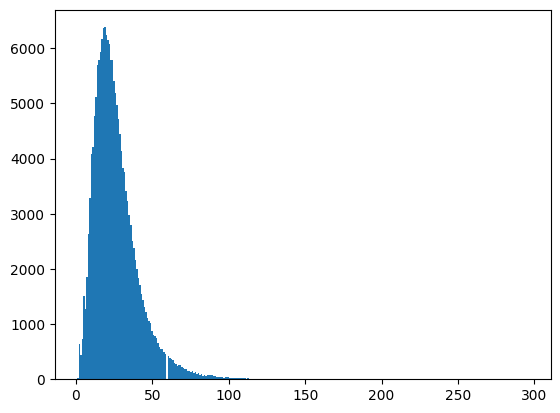

In [71]:
plt.hist(sentences_lengths, bins=300);

In [72]:
seq_len = int(np.percentile(sentences_lengths, 95))
seq_len

55

In [76]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=68000,
    output_sequence_length=seq_len,
)
text_vectorizer.adapt(train_sentences)

In [77]:
random_sentence = random.choice(train_sentences)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([random_sentence])}")


Text:
we prospectively include @ patients with neer 's @ - or @-part proximal humerus fractures .

Length of text: 16

Vectorized text:
[[   43  1125   637    12     7 25589   130    16   732  1844 11580  1285
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [78]:
embedding = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    mask_zero=True,
)

In [79]:
random_sentence = random.choice(train_sentences)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([random_sentence])}")
print(f"\nEmbedded text:\n{embedding(text_vectorizer([random_sentence]))}")
print(f"\nEmbedded text shape:\n{embedding(text_vectorizer([random_sentence])).shape}")

Text:
severe childhood obesity has become a major health problem , and effective , evidence-based interventions are needed .

Length of text: 18

Vectorized text:
[[ 289 1527  793  139 2516    8  347   97 1339    3  137 1439  265   58
   440    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded text:
[[[-0.03294113 -0.02167924  0.02910298 ...  0.00232742 -0.02655081
    0.01744738]
  [ 0.03468526 -0.0410308  -0.04482001 ... -0.03619912  0.00131617
   -0.01736914]
  [-0.02755678 -0.02745595 -0.004673   ...  0.01924001 -0.03601673
   -0.01606338]
  ...
  [-0.0195901  -0.03270773  0.03523308 ...  0.04745269  0.0022792
    0.00082593]
  [-0.0195901  -0.03270773  0.03523308 ...  0.04745269  0.0022792
    0.00082593]
  [-0.0195901  -0.03270773  0.03523308 ...  0.04745269  0.0022792
    0.00082593]]]

Embedded text shape:
(1, 55, 128

In [80]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [81]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 1: Conv1D

Epoch 1/3
562/562 [==============================] - 7s 8ms/step - loss: 0.9223 - accuracy: 0.6353 - val_loss: 0.6871 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6584 - accuracy: 0.7552 - val_loss: 0.6337 - val_accuracy: 0.7680
Epoch 3/3
945/945 [==============================] - 3s 3ms/step


{'accuracy': 78.5681186283596,
 'precision': 0.7826488388182563,
 'recall': 0.785681186283596,
 'f1': 0.7829437568266986}

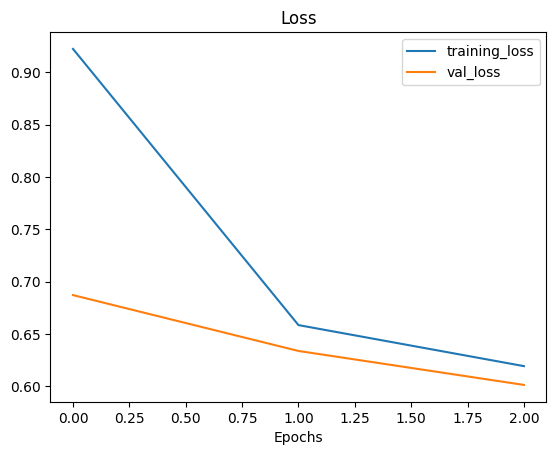

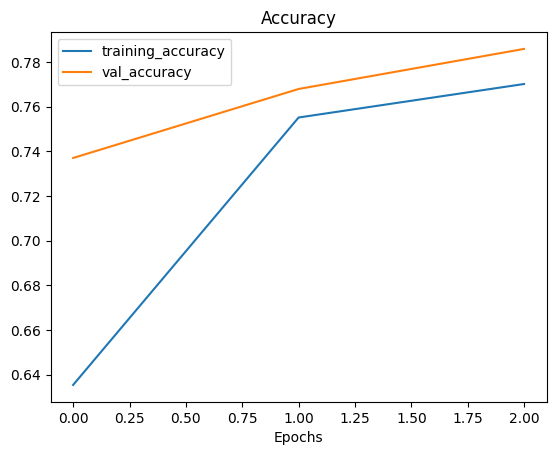

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=68000,
    output_sequence_length=seq_len,
)

text_vectorizer.adapt(train_sentences)

embedding = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    mask_zero=True,
)

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', padding="same")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(classes_count, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_1_history = model_1.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)),
)

model_1_preds = tf.argmax(model_1.predict(val_sentences), axis=1)

model_1_results = calculate_results(val_labels_encoded, model_1_preds)

plot_loss_curves(model_1_history)

model_1_results

### Model 2: Feature extraction with pretrained token embeddings

In [82]:
hub_embedding = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
    trainable=False,
    name="universal_sentence_encoder",
)

In [83]:
random_sentence = random.choice(train_sentences)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nEmbedded text:\n{hub_embedding([random_sentence])}")

Text:
over half of participants reported abdominal pain in the past two weeks , and pain was present among those with and without clinical disease activity .

Length of text: 26



Embedded text:
[[-6.51663765e-02  2.80406438e-02 -1.61889102e-02  4.78873914e-03
  -3.43160927e-02  4.09116000e-02  1.71157792e-02  5.73292142e-03
   1.00744423e-02  1.44399572e-02  8.92655253e-02 -5.83669543e-02
   7.20041171e-02 -5.79682887e-02 -3.00882235e-02  4.98423614e-02
  -9.27081406e-02 -2.51539573e-02  2.55088266e-02  1.50052710e-02
   8.62685293e-02  3.46330628e-02 -5.09593710e-02 -1.55969290e-04
   1.11056818e-02  5.41152880e-02 -4.71510850e-02 -2.62176152e-02
  -1.12723913e-02  3.89105901e-02  4.69556730e-03  9.29267853e-02
   5.65816388e-02  9.52523388e-03  3.99913825e-02  2.22884659e-02
   1.33154774e-02 -6.04858920e-02 -2.22458206e-02 -4.75504249e-02
  -7.57228136e-02  8.00741687e-02 -4.44406550e-03 -5.98735996e-02
   7.17967227e-02  5.74524589e-02 -6.70419782e-02  1.14310319e-02
   1.46849630e-02  6.48935093e-03 -2.45823921e-03 -4.54171300e-02
  -3.08100209e-02  4.54199314e-02  6.15581609e-02  4.06076647e-02
  -6.81591481e-02  2.33169757e-02  5.06579876e-03  3.1372614

Epoch 1/3
562/562 [==============================] - 26s 42ms/step - loss: 0.9129 - accuracy: 0.6509 - val_loss: 0.7963 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 33s 59ms/step - loss: 0.7682 - accuracy: 0.7021 - val_loss: 0.7538 - val_accuracy: 0.7064
Epoch 3/3
945/945 [==============================] - 14s 14ms/step


{'accuracy': 71.49477028995102,
 'precision': 0.7154767099909466,
 'recall': 0.7149477028995102,
 'f1': 0.7123828798924989}

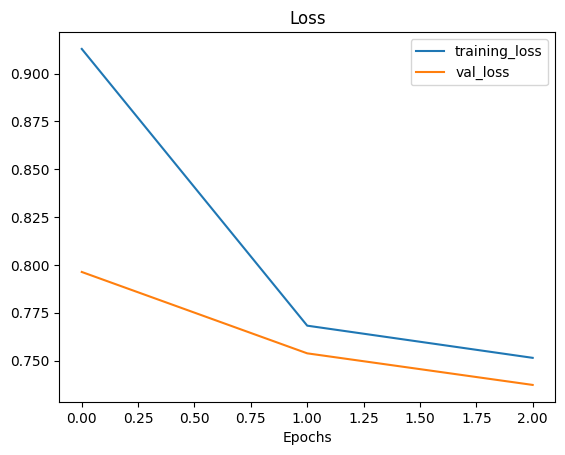

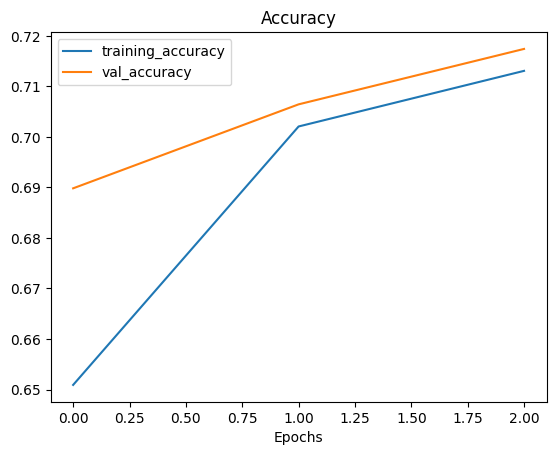

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = hub_embedding(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(classes_count, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_2_history = model_2.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)),
)

model_2_preds = tf.argmax(model_2.predict(val_sentences), axis=1)
model_2_results = calculate_results(val_labels_encoded, model_2_preds)

plot_loss_curves(model_2_history)

model_2_results

### Model 3: Conv1D with character embeddings

In [84]:
train_chars = [" ".join(list(sentence)) for sentence in train_sentences]
val_chars = [" ".join(list(sentence)) for sentence in val_sentences]
test_chars = [" ".join(list(sentence)) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [85]:
char_lens = [len(sentence) for sentence in train_sentences]

min(char_lens), np.mean(char_lens), max(char_lens)

(1, 149.3662574983337, 1386)

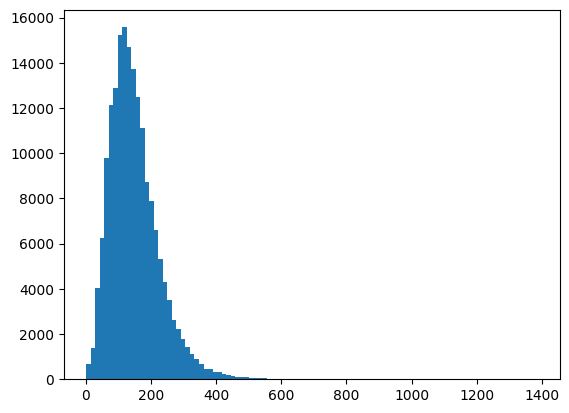

In [86]:
plt.hist(char_lens, bins=100);

In [87]:
seq_char_len = int(np.percentile(char_lens, 90))
seq_char_len

247

In [88]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [89]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=seq_char_len,
    # standardize=None,
)

char_vectorizer.adapt(train_chars)

In [90]:
random_sentence = random.choice(train_chars)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nVectorized text:\n{char_vectorizer([random_sentence])}")


Text:
f e m - p r e p   w a s   a   r a n d o m i z e d   ,   b l i n d e d   ,   p l a c e b o - c o n t r o l l e d   t r i a l   o f   d a i l y   t d f - f t c   a m o n g   w o m e n   i n   a f r i c a   .

Length of text: 87

Vectorized text:
[[17  2 15 14  8  2 14 20  5  9  5  8  5  6 10  7 15  4 25  2 10 22 12  4
   6 10  2 10 14 12  5 11  2 22  7 11  7  6  3  8  7 12 12  2 10  3  8  4
   5 12  7 17 10  5  4 12 19  3 10 17 17  3 11  5 15  7  6 18 20  7 15  2
   6  4  6  5 17  8  4 11  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

In [91]:
char_embedding = tf.keras.layers.Embedding(
    input_dim=len(char_vectorizer.get_vocabulary()),
    output_dim=25,
    mask_zero=True,
)

In [92]:
random_sentence = random.choice(train_chars)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nEmbedded text:\n{char_embedding(char_vectorizer([random_sentence]))}")
print(f"\nEmbedded text shape:\n{char_embedding(char_vectorizer([random_sentence])).shape}")


Text:
t h e r e f o r e   ,   i c e   d o e s   n o t   s e e m   t o   d e c r e a s e   m u s c l e   p e r f u s i o n   w h e n   b l o o d   f l o w   i s   e l e v a t e d   ,   a s   i t   w o u l d   b e   d u r i n g   i n f l a m m a t i o n   .

Length of text: 103

Embedded text:
[[[ 0.03506615 -0.02039539  0.01663078 ...  0.02150023  0.00291206
    0.01149317]
  [-0.02982162  0.010093   -0.02693087 ...  0.01641141  0.04221907
    0.04905169]
  [-0.01283972 -0.02553709  0.01875505 ... -0.01373972  0.0134261
    0.04719646]
  ...
  [-0.01285075  0.04913864 -0.0498476  ...  0.00326896  0.02537917
    0.02553247]
  [-0.01285075  0.04913864 -0.0498476  ...  0.00326896  0.02537917
    0.02553247]
  [-0.01285075  0.04913864 -0.0498476  ...  0.00326896  0.02537917
    0.02553247]]]

Embedded text shape:
(1, 247, 25)


In [93]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2741 - accuracy: 0.4863 - val_loss: 1.0593 - val_accuracy: 0.5765
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0193 - accuracy: 0.5864 - val_loss: 0.9504 - val_accuracy: 0.6247
Epoch 3/3
945/945 [==============================] - 3s 3ms/step


{'accuracy': 65.18932874354562,
 'precision': 0.6423840127481475,
 'recall': 0.6518932874354562,
 'f1': 0.6411370959909005}

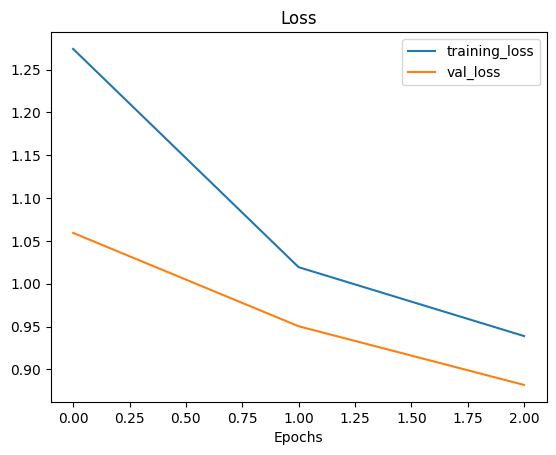

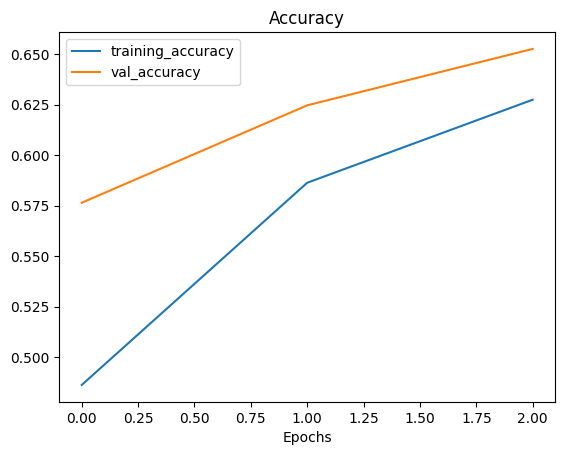

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = tf.keras.layers.Conv1D(64, 5, activation="relu")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(classes_count, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_3_history = model_3.fit(
    train_char_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset)),
)

model_3_preds = tf.argmax(model_3.predict(val_char_dataset), axis=1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)

plot_loss_curves(model_3_history)

model_3_results

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [94]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Epoch 1/5
562/562 [==============================] - 81s 143ms/step - loss: 0.9582 - accuracy: 0.6167 - val_loss: 0.7715 - val_accuracy: 0.7045
Epoch 2/5
562/562 [==============================] - 85s 151ms/step - loss: 0.7845 - accuracy: 0.6968 - val_loss: 0.7033 - val_accuracy: 0.7314
Epoch 3/5
562/562 [==============================] - 78s 138ms/step - loss: 0.7638 - accuracy: 0.7055 - val_loss: 0.6830 - val_accuracy: 0.7397
Epoch 4/5
562/562 [==============================] - 88s 157ms/step - loss: 0.7340 - accuracy: 0.7205 - val_loss: 0.6610 - val_accuracy: 0.7500
Epoch 5/5
945/945 [==============================] - 55s 59ms/step


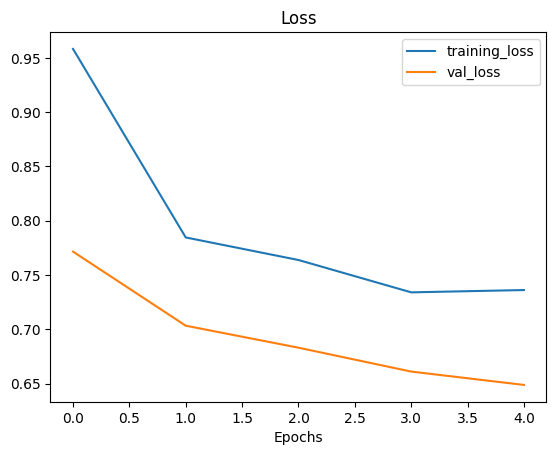

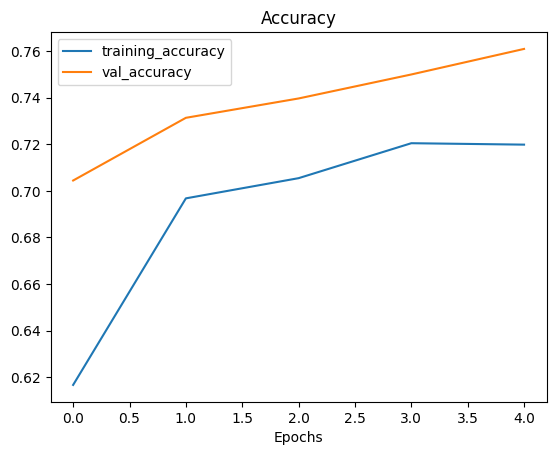

In [ ]:
# 1. Setup token inputs/model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = hub_embedding(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - adding in dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(classes_count, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name="model_4_token_and_char_embeddings",
)

# 6. Compile model
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)


model_4_history = model_4.fit(
    train_char_token_dataset,
    epochs=5,
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1 * len(val_char_token_dataset)),
)

model_4_preds = tf.argmax(model_4.predict(val_char_token_dataset), axis=1)
model_4_results = calculate_results(val_labels_encoded, model_4_preds)

plot_loss_curves(model_4_history)

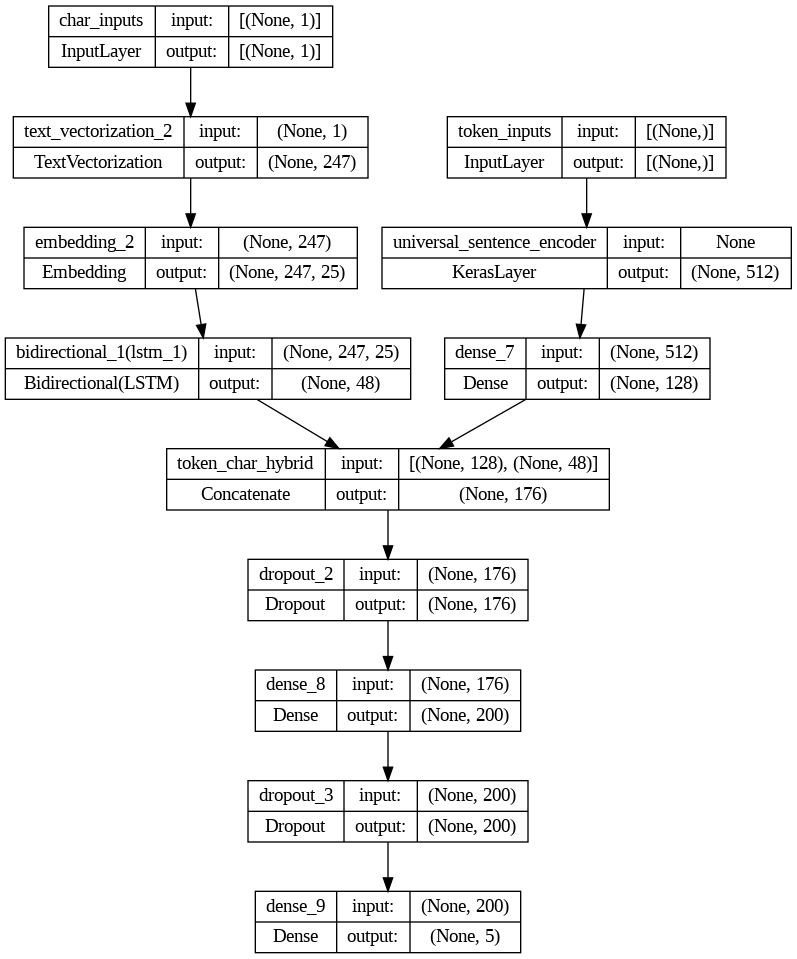

In [ ]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

### Model 5: Transfer learning with pretrained token embedding + character embedding + positional embedding

#### Creating position embeddings

In [96]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

In [97]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:30], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(30, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [98]:
train_df["total_lines"].value_counts()

total_lines
12    24456
11    23639
13    22125
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

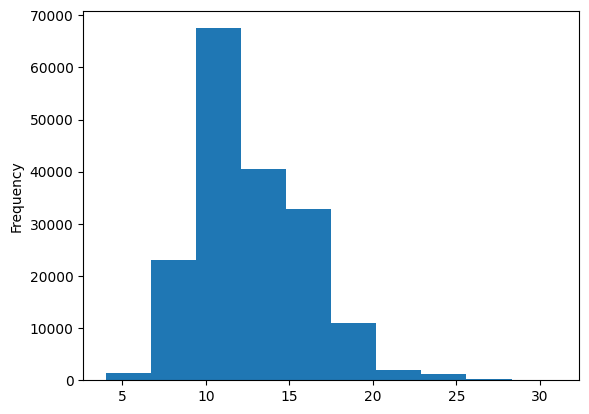

In [99]:
train_df["total_lines"].plot.hist()

In [100]:
np.percentile(train_df['total_lines'], 95)

19.0

In [101]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:20], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

In [102]:
from tensorflow.keras import layers

embedding = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    mask_zero=True,
)

token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embedding = embedding(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

total_lines_inputs = layers.Input(shape=(20,), name='total_lines_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

token_char_concatenate = layers.Concatenate(name="token_char_concatenate")([token_model.output, char_model.output])

drop_out = layers.Dense(256, activation='relu')(token_char_concatenate)
drop_out = layers.Dropout(0.5)(drop_out)

final_concatenate = layers.Concatenate(name='final_concatenate')([drop_out, line_number_model.output, total_lines_model.output])

outputs = layers.Dense(5, activation='softmax', name='output_layer')(final_concatenate)

model_5 = tf.keras.Model([token_model.input, char_model.input, line_number_model.input, total_lines_model.input], outputs)

TypeError: Expected string passed to parameter 'y' of op 'NotEqual', got 0 of type 'int' instead. Error: Expected string, but got 0 of type 'int'.

In [ ]:
model_5.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_4 (Text  (None, 247)                  0         ['char_inputs[0][0]']         
 Vectorization)                                                                                   
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

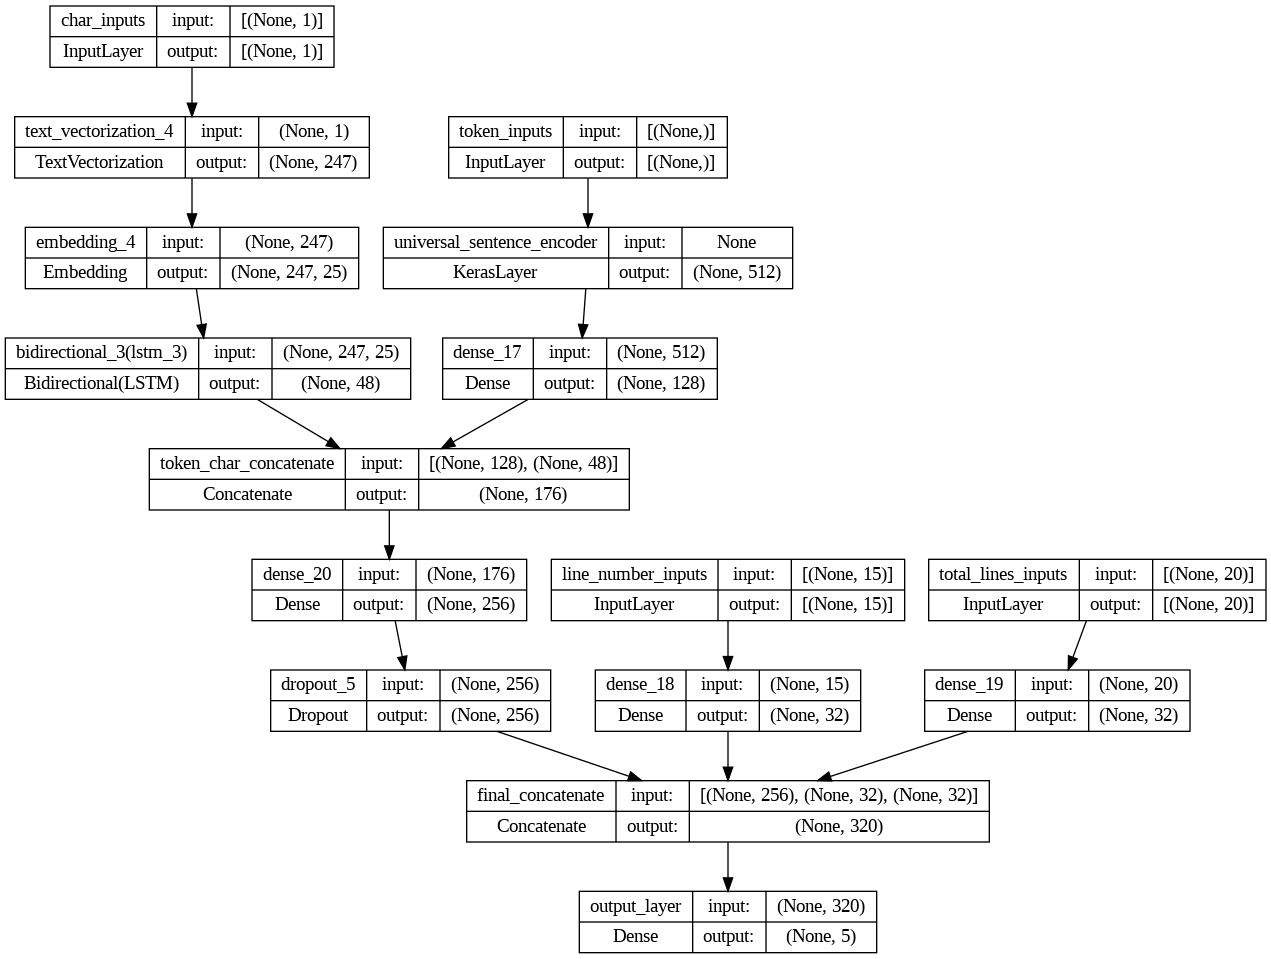

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices([train_sentences,
                                                                train_chars,
                                                                train_line_numbers_one_hot,
                                                                train_total_lines_one_hot])
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Data.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices([val_sentences,
                                                              val_chars,
                                                              val_line_numbers_one_hot,
                                                              val_total_lines_one_hot])
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Data.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices([test_sentences,
                                                              test_chars,
                                                              test_line_numbers_one_hot,
                                                              test_total_lines_one_hot])
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Data.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

NameError: name 'train_char_token_pos_data' is not defined

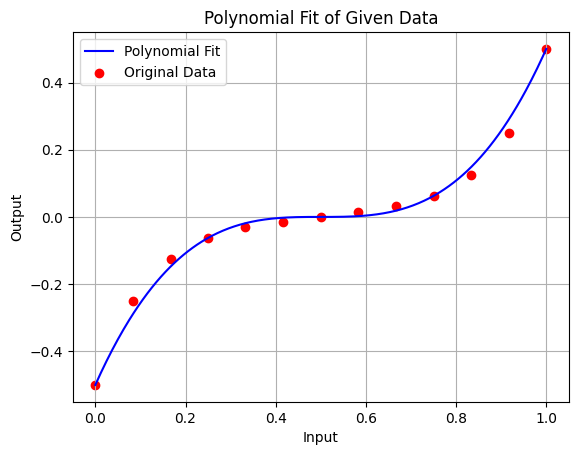

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def polynomial_mapping(x):
    return np.poly1d([ 4, -6,  3, -0.5 ])(x)

# Original data points
x_values = np.array([0, 0.083, 0.167, 0.25, 0.333, 0.416, 0.5, 0.583, 0.667, 0.75, 0.833, 0.917, 1])
y_values = np.array([-0.5, -0.25, -0.125, -0.0625, -0.03125, -0.015625, 0, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5])

# Generate data for plotting the polynomial curve
x_plot = np.linspace(0, 1, 400)
y_plot = polynomial_mapping(x_plot)

# Plotting
plt.plot(x_plot, y_plot, label='Polynomial Fit', color='blue')
plt.scatter(x_values, y_values, label='Original Data', color='red')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.title('Polynomial Fit of Given Data')
plt.grid(True)
plt.show()


In [26]:
mapping_function

poly1d([ 3.99366057, -5.9905665 ,  2.96313451, -0.4831219 ])